Мышковец С.А., v.1 01.05.2023

**Решение задачи:**

ДЗ - оценить возраст человека по изображению. 

Применить в любой задачи из ДЗ (например в задачи где мы определяли возраст) механизм внимания (слой MultiheadAttention) в место основного или вместе с основным телом модели. 
Цель - попробовать применять данный слой.  

**Вывод**

| Модель | train | valid | test |
| ----------- | ----------- | ----------- |----------- |
| custom_model | 5,23 | 7,09 | 7,14 |
| mh_at_custom_model | 4,56 | 6,77 | 6.97 |

Применение слоя MultiHeadAttention улучшило результат модели.

# Загрузим необходимые библиотеки и проведем разведовательный анализ данных.

In [44]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualization
import cv2 # for ingesting images
print('OpenCV: %s' % cv2.__version__) # print version
import matplotlib 
import matplotlib.pyplot as plt # or data visualizationa
print('matplotlib: %s' % matplotlib.__version__) # print version
import graphviz # for showing model diagram
print('graphviz: %s' % graphviz.__version__) # print version

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, AveragePooling2D, Activation, GlobalMaxPool2D, GlobalAveragePooling2D, Input, MaxPool2D, MultiHeadAttention
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import gc

import sys
import os

OpenCV: 4.7.0
matplotlib: 3.6.3
graphviz: 0.20.1


In [2]:
# Define loss visualization function
def test_val_graph (history,train,val):
    plt.plot(history.history[train], label='Точность на обучающем наборе')
    plt.plot(history.history[val], label='Точность на проверочном наборе')
    plt.xlabel('Цикл обучения')
    plt.ylabel('Точность')
    plt.legend()
    plt.show()
    pass;

In [3]:
import os
main_dir = os.getcwd()

In [4]:
main_dir

'/Users/sviatlanamyshkavets/Documents/Courses/DS TM/47 Композиция глубоких сетей/HW33_Myshkavets S.A.'

In [5]:
# Specify the location of images after you have downloaded them
ImgLocation = main_dir + "/UTKFace"

In [6]:
# Extract age values from file names
age = []
for file in os.listdir(ImgLocation):
    file = int(file.split('_')[0])
    age.append(file)

In [7]:
len(age)

23708

In [8]:
# Extract paths for further data exploration
full_path = []
for file in os.listdir(ImgLocation):
    path = ImgLocation + '/' + file
    full_path.append(path)

In [9]:
# Create pd DataFrame
df = pd.DataFrame({'age': age,  
                   'full_path': full_path, 
                   }
                 )

In [10]:
df.head()

,age,full_path
0,9,/Users/sviatlanamyshkavets/Documents/Courses/D...
1,36,/Users/sviatlanamyshkavets/Documents/Courses/D...
2,86,/Users/sviatlanamyshkavets/Documents/Courses/D...
3,26,/Users/sviatlanamyshkavets/Documents/Courses/D...
4,1,/Users/sviatlanamyshkavets/Documents/Courses/D...


In [11]:
df.describe()

,age
count,23708.000000
mean,33.303484
std,19.886112
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23708 non-null  int64 
 1   full_path  23708 non-null  object
dtypes: int64(1), object(1)
memory usage: 370.6+ KB


# Выведем фотографии из файлов, частично проверим верность целевых меток.

**При необходимости при помощи кода ниже пробежимся по папкам и проверим фото детей до 18 лет, удалим явные выбросы. В нашем случае выбран очищенный датасет.**

In [ ]:
test = df[df['age']==1]
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for i in test['full_path']:
#     img = cv2.imread(file)
    img = mpimg.imread(i)
    imgplot = plt.imshow(img)
    plt.xlabel(i)
    print(i)
    plt.show()

array([[<AxesSubplot: title={'center': 'age'}>]], dtype=object)

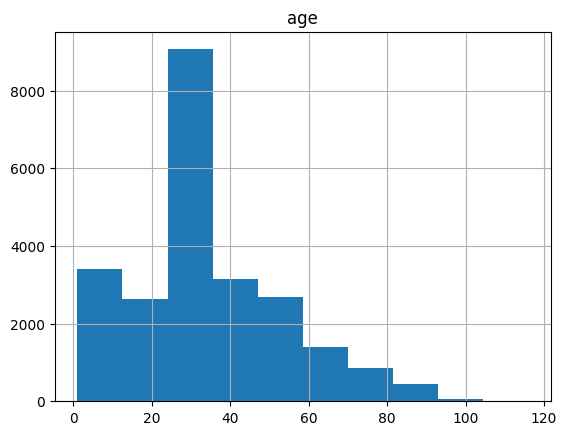

In [13]:
# Explore age distribution
df.hist()

In [14]:
df.groupby('age')['age'].count().sort_values()

age
111       1
103       1
101       2
91        2
115       3
       ... 
24      859
35      880
28      918
1      1123
26     2197
Name: age, Length: 104, dtype: int64

In [15]:
# Delete age values over 99 years
index_age_100 = df[df['age']>99].index
df.drop(index_age_100 , inplace=True)

In [15]:
# from sklearn.preprocessing import LabelEncoder
# labelencoder = LabelEncoder()
# df['age'] = labelencoder.fit_transform(df['age'])

**Разделим данные на тренировочную, тестовую и валидационную выборку.**

In [16]:
from sklearn.model_selection import train_test_split

y = df['age']
X = df['full_path']

In [17]:
train_full, test= train_test_split(
    df, test_size=0.12, stratify=df['age'], random_state=0)

In [18]:
train_full.groupby('age')['age'].count()

age
1     988
2     424
3     254
4     240
5     173
     ... 
92     12
93      4
95      8
96     15
99      8
Name: age, Length: 96, dtype: int64

In [19]:
train_full.shape

(20834, 2)

In [20]:
# Extract valid from train
train, valid = train_full[:-5500], train_full[-5500:]

In [21]:
test.shape

(2842, 2)

In [22]:
test.groupby('age')['age'].count()

age
1     135
2      58
3      35
4      33
5      23
     ... 
92      1
93      1
95      1
96      2
99      1
Name: age, Length: 95, dtype: int64

In [77]:
# Create necessary folders for image storage
os.makedirs('train')

In [78]:
os.makedirs('test')

In [79]:
os.makedirs('valid')

In [80]:
# Create lists for train/test/valid images
train_files = []
for i in train['full_path']:
    train_files.append(i)
for a in train['age']:
    train_files.append(a)

In [81]:
test_files = []
for i in test['full_path']:
    test_files.append(i)
for a in test['age']:
    test_files.append(a)

In [82]:
valid_files = []
for i in valid['full_path']:
    valid_files.append(i)
for a in valid['age']:
    valid_files.append(a)

In [83]:
train_dir = main_dir + '/train'
test_dir = main_dir + '/test'
valid_dir = main_dir + '/valid'

In [84]:
for filename in os.listdir(ImgLocation):
    if filename != '.DS_Store':
        # for i in os.listdir(ImgLocation + '/' + filename):
        file = ImgLocation + '/' + filename
        if file in train_files:
            img = cv2.imread(file)
            img = cv2.resize(img, (224, 224))
            if img.shape[2] == 1:
                img = np.dstack([img, img, img]) # Some images are in  greyscale (1 channel), 
                                                     # therefore convert them to 3 channel
            path = train_dir
            cv2.imwrite(os.path.join(path, filename), img)
        if file in test_files:
            img = cv2.imread(file)
            img = cv2.resize(img, (224, 224))
            if img.shape[2] == 1:
                img = np.dstack([img, img, img])
            path = test_dir
            cv2.imwrite(os.path.join(path, filename), img)
        if file in valid_files:
            img = cv2.imread(file)
            img = cv2.resize(img, (224, 224))
            if img.shape[2] == 1:
                img = np.dstack([img, img, img])
            path = valid_dir
            cv2.imwrite(os.path.join(path, filename), img)

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
train_datagen=ImageDataGenerator(rescale=1./255.)

In [25]:
test_datagen=ImageDataGenerator(rescale=1./255.)

In [26]:
valid_datagen=ImageDataGenerator(rescale=1./255.)

In [27]:
TARGET_SIZE = (224,224)

train_gen=train_datagen.flow_from_dataframe(
dataframe=train,
directory=main_dir + '/train',
x_col="full_path",
y_col="age",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE
)

valid_gen=train_datagen.flow_from_dataframe(
dataframe=valid,
directory=main_dir + '/valid',
x_col="full_path",
y_col="age",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE
)

test_gen=test_datagen.flow_from_dataframe(
dataframe=test,
directory=main_dir + '/test',
x_col="full_path",
y_col="age",
batch_size=32,
seed=42,
shuffle=False,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE
)

Found 15334 validated image filenames.
Found 5500 validated image filenames.
Found 2842 validated image filenames.


# Определим и обучим несколько моделей.

**Custom model**

In [42]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, AveragePooling2D, Activation, GlobalMaxPool2D, GlobalAveragePooling2D, Input, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [110]:
target_size = (224,224,3) 
input = Input(shape= target_size) 

x = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(input) 
x = MaxPool2D(2,2)(x) 

x = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x) 
x = MaxPool2D(2,2)(x) 

x = Conv2D(filters=128, kernel_size=(3,3), activation='relu')(x) 
x = MaxPool2D(2,2)(x) 

x = Conv2D(filters=256, kernel_size=(3,3), activation='relu')(x) 
x = MaxPool2D(2,2)(x) 
x = GlobalMaxPool2D()(x)
x = Dropout(0.25)(x) 
x = Flatten()(x) 
x = Dense(units=128, activation='relu')(x) 
x = Dense(units=64, activation='relu')(x) 
output = Dense(units=1, activation='linear')(x) 

custom_model  = Model(input, output, name= 'Custom_Model')

In [111]:
custom_model.summary()

Model: "Custom_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_19 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 52, 52, 128)      

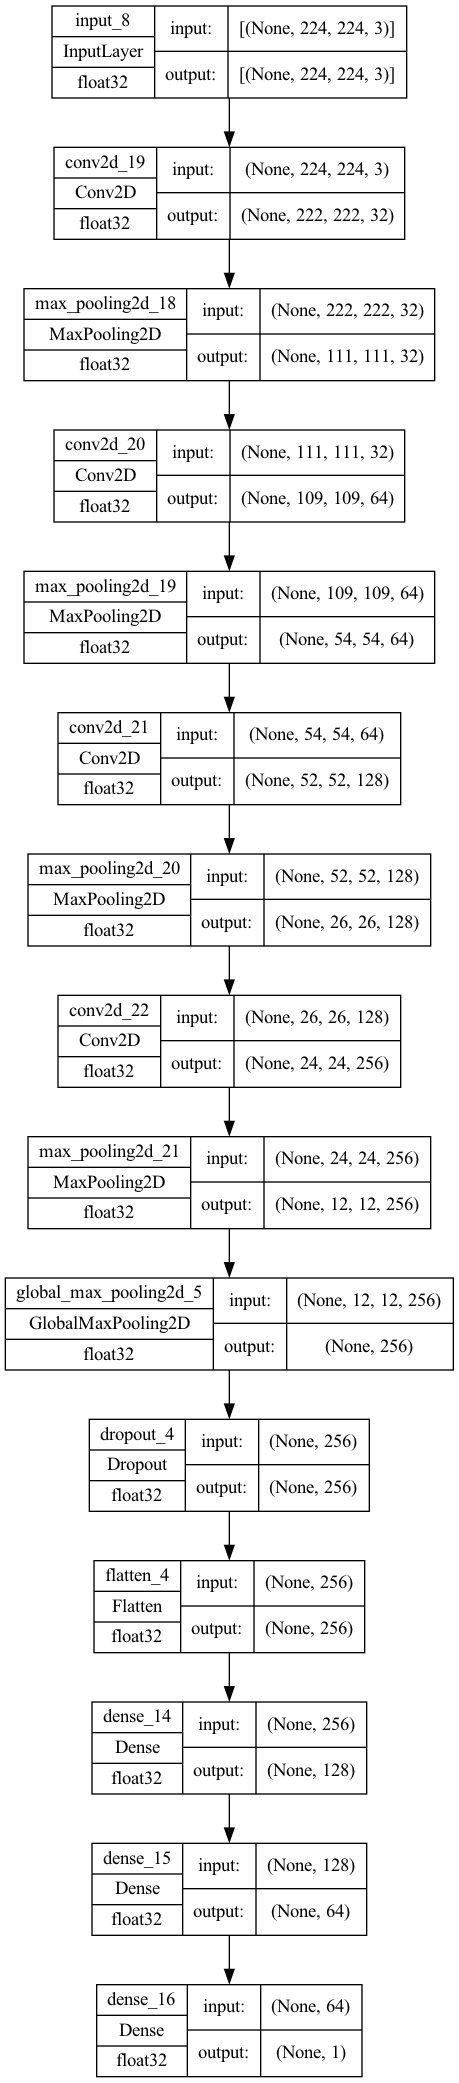

In [112]:
# show model structure 
from tensorflow.keras.utils import plot_model 
plot_model(custom_model,show_shapes=True,
    show_dtype=True,
    show_layer_names=True)

In [314]:
# compile model
custom_model.compile(loss='mse', optimizer='rmsprop', metrics=['mae']) 

# initialize callbacks 
reduceLR = ReduceLROnPlateau(monitor='val_mae', patience= 3, verbose= 1, mode='min', factor=  0.2, min_lr = 1e-6) 

early_stopping = EarlyStopping(monitor='val_mae', patience = 5 , verbose=1, mode='min', restore_best_weights= True) 

checkpoint = ModelCheckpoint('CustomModel.weights.hdf5', monitor='val_mae', verbose=1, save_best_only=True, mode= 'min') 

callbacks= [reduceLR, early_stopping, checkpoint]

In [315]:
epochs = 30 
custom_model.fit(train_gen, validation_data=valid_gen, epochs= epochs, callbacks= callbacks)

Epoch 1/30


2023-04-28 09:26:12.908151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


494/494 [==============================] - ETA: 0s - loss: 467.8811 - mae: 16.6850

2023-04-28 09:26:58.101621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_mae improved from inf to 16.53504, saving model to CustomModel.weights.hdf5
494/494 [==============================] - 50s 96ms/step - loss: 467.8811 - mae: 16.6850 - val_loss: 418.3416 - val_mae: 16.5350 - lr: 0.0010
Epoch 2/30
494/494 [==============================] - ETA: 0s - loss: 422.9438 - mae: 15.8779
Epoch 2: val_mae improved from 16.53504 to 16.41605, saving model to CustomModel.weights.hdf5
494/494 [==============================] - 45s 92ms/step - loss: 422.9438 - mae: 15.8779 - val_loss: 404.0142 - val_mae: 16.4160 - lr: 0.0010
Epoch 3/30
494/494 [==============================] - ETA: 0s - loss: 398.8951 - mae: 15.4267
Epoch 3: val_mae improved from 16.41605 to 14.64964, saving model to CustomModel.weights.hdf5
494/494 [==============================] - 46s 92ms/step - loss: 398.8951 - mae: 15.4267 - val_loss: 377.7776 - val_mae: 14.6496 - lr: 0.0010
Epoch 4/30
494/494 [==============================] - ETA: 0s - loss: 376.5752 - mae: 14.9819
Epoch 4: val_m

In [ ]:
test_val_graph (custom_model.fit(train_gen, validation_data=valid_gen, epochs= epochs, callbacks= callbacks),'mae','val_mae')

In [317]:
del custom_model

In [318]:
gc.collect()

4565

In [320]:
# import tensorflow as tf
custom_model =  tf.keras.models.load_model('CustomModel.weights.hdf5')

In [321]:
# Evaluate the model 
custom_model.evaluate(test_gen)

2023-04-28 09:49:43.372372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


74/74 [==============================] - 3s 31ms/step - loss: 103.9018 - mae: 7.1424


[103.90179443359375, 7.142443656921387]

**Модель со слоем MultiHeadAttention.**

In [61]:
# Задаем параметры сети
input_shape = (224,224,3) 

# Создаем сверточную нейронную сеть
input_layer = Input(shape=input_shape)
x = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(input_layer) 
x = MaxPool2D(2,2)(input_layer) 

x = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x) 
x = MaxPool2D(2,2)(x) 

x = Conv2D(filters=128, kernel_size=(3,3), activation='relu')(x) 
x = MaxPool2D(2,2)(x) 

x = Conv2D(filters=256, kernel_size=(3,3), activation='relu')(x) 
x = MaxPool2D(2,2)(x) 
x = GlobalMaxPool2D()(x)
x = Dropout(0.25)(x) 
x = Flatten()(x) 
x = Dense(units=128, activation='relu')(x) 
x = Dense(units=64, activation='relu')(x) 

# Создаем слой механизма внимания
x = MultiHeadAttention(num_heads=8, key_dim=512, attention_axes=(0, 1))(x, x)
x = Dropout(0.5)(x)

# Добавляем выходной слой
output_layer = Dense(1, activation='linear')(x)

# Создаем модель
mh_at_custom_model = Model(inputs=input_layer, outputs=output_layer)
mh_at_custom_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 max_pooling2d_81 (MaxPooling2D  (None, 112, 112, 3)  0          ['input_25[0][0]']               
 )                                                                                                
                                                                                                  
 conv2d_82 (Conv2D)             (None, 110, 110, 64  1792        ['max_pooling2d_81[0][0]']       
                                )                                                          

In [ ]:
# show model structure 
from tensorflow.keras.utils import plot_model 
plot_model(mh_at_custom_model,show_shapes=True,
    show_dtype=True,
    show_layer_names=True)

In [64]:
# compile model
mh_at_custom_model.compile(loss='mse', optimizer='rmsprop', metrics=['mae']) 

# initialize callbacks 
reduceLR = ReduceLROnPlateau(monitor='val_mae', patience= 3, verbose= 1, mode='min', factor=  0.2, min_lr = 1e-6) 

early_stopping = EarlyStopping(monitor='val_mae', patience = 5 , verbose=1, mode='min', restore_best_weights= True) 

checkpoint = ModelCheckpoint('Multihead_Attenion_CustomModel.weights.hdf5', monitor='val_mae', verbose=1, save_best_only=True, mode= 'min') 

callbacks= [reduceLR, early_stopping, checkpoint]

In [65]:
# train model
epochs = 30 
mh_at_custom_model.fit(train_gen, validation_data=valid_gen, epochs= epochs, callbacks= callbacks)

Epoch 1/30


2023-05-01 11:56:30.711969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


480/480 [==============================] - ETA: 0s - loss: 519.4298 - mae: 17.1745

2023-05-01 11:57:02.212673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_mae improved from inf to 14.59214, saving model to Multihead_Attenion_CustomModel.weights.hdf5
480/480 [==============================] - 37s 73ms/step - loss: 519.4298 - mae: 17.1745 - val_loss: 353.1433 - val_mae: 14.5921 - lr: 0.0010
Epoch 2/30
480/480 [==============================] - ETA: 0s - loss: 327.2922 - mae: 13.9769
Epoch 2: val_mae improved from 14.59214 to 12.43668, saving model to Multihead_Attenion_CustomModel.weights.hdf5
480/480 [==============================] - 34s 72ms/step - loss: 327.2922 - mae: 13.9769 - val_loss: 254.8083 - val_mae: 12.4367 - lr: 0.0010
Epoch 3/30
480/480 [==============================] - ETA: 0s - loss: 250.0003 - mae: 12.0973
Epoch 3: val_mae improved from 12.43668 to 11.32623, saving model to Multihead_Attenion_CustomModel.weights.hdf5
480/480 [==============================] - 36s 76ms/step - loss: 250.0003 - mae: 12.0973 - val_loss: 215.0585 - val_mae: 11.3262 - lr: 0.0010
Epoch 4/30
480/480 [==============================]

In [66]:
del mh_at_custom_model

In [67]:
gc.collect()

30066

In [68]:
# Load trained model 
mh_at_custom_model = tf.keras.models.load_model('Multihead_Attenion_CustomModel.weights.hdf5')

In [69]:
# Evaluate the model 
mh_at_custom_model.evaluate(test_gen)

 1/89 [..............................] - ETA: 20s - loss: 66.6144 - mae: 5.5758

2023-05-01 12:15:27.528356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - 3s 28ms/step - loss: 100.7148 - mae: 6.9767


[100.71483612060547, 6.976693630218506]

**Вывод**

| Модель | train | valid | test |
| ----------- | ----------- | ----------- |----------- |
| custom_model | 5,23 | 7,09 | 7,14 |
| mh_at_custom_model | 4,56 | 6,77 | 6.97 |

Применение слоя MultiHeadAttention улучшило результат модели.